## CHALLENGE 1
------------------------

I've decided to work on this particular dataset because I want to explore how to work on unbalanced data, a situation that can easily happen in real-life cases (the most famous cases are for breast cancer recognition and, as shown in this notebook, fraud detaction). 

The Kaggle dataset I'm using contains 284807 transactions, and 492 of them (0.017%) are classified as frauds.
I will try to use Logistic Regression for correctly predicting whether a transaction is fraudulent or not, using two different approaches:

1- Undersampling: I will randomly extract a sample of data with a 50:50 ratio between frauds and normal and train the model on this subsample. It's an approach that involves a big loss of information (we will have 492 non-frauds rows instead of 284315) 

2- Oversampling: using SMOTE, a technique that populates the dataset with new syntethic points, balancing the ratio.

Thanks to Janio Bachmann for the help: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets



In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

#model used: Logistic Regression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import NearMiss

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

from sklearn.metrics import plot_confusion_matrix

In [14]:
data_folder = Path("C:/Users/david/Desktop/Davide/Progetti Python/Credit Card - Unbalanced")
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Shape of the dataset: (284807, 31)


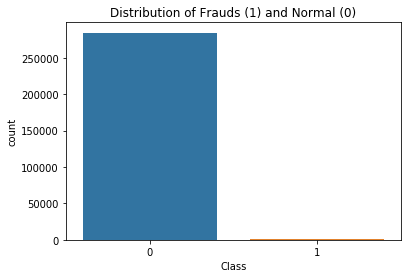

In [16]:
sns.countplot('Class', data=df)
plt.title('Distribution of Frauds (1) and Normal (0)')
print("Shape of the dataset: {}".format(df.shape))


## Preprocessing
Scaling with Robustscaler (less impact from outliers). 
Most of the data is already scaled, we only need Amount and Time!

In [17]:
scaler = RobustScaler()

df['amountnew'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['timenew'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

amountnew = df['amountnew']
timenew = df['timenew']

df.drop(['amountnew', 'timenew'], axis=1, inplace=True)
df.insert(0, 'Amount_Scaled', amountnew)
df.insert(1, 'Time_Scaled', timenew)
df.head()

,Amount_Scaled,Time_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Approach 1: Undersampling. 
Let's extract a sample of the data with 50:50 Frauds/no Frauds and let's work on it first. 
We have 492 frauds, so let's shuffle the dataframe and extract the first 492 non-frauds (and concatenate them)

In [18]:
df = df.sample(frac=1)

fdf = df.loc[df['Class'] == 1]
nfdf = df.loc[df['Class'] == 0][:492]

concatdf = pd.concat([fdf, nfdf])

df2 = concatdf.sample(frac=1, random_state=1)
df2.head()

,Amount_Scaled,Time_Scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
80116,0.080905,-0.309543,1.259624,0.204025,-0.031377,0.898056,0.053882,-0.383476,0.127147,-0.091567,...,-0.121702,-0.241689,-0.786790,-0.080569,-0.686372,0.551254,-0.499642,0.007086,0.018416,0
6336,-0.293440,-0.906366,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,...,0.269773,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1
243749,-0.293440,0.791433,-3.576362,3.299436,-7.460433,7.783634,-0.398549,-1.968441,-3.110476,-0.328404,...,-0.181455,0.540731,0.719526,0.379249,-0.616962,-0.442811,0.359841,-2.651825,0.422184,1
130454,-0.293440,-0.062689,-0.443385,-0.034591,1.823366,-1.737530,-0.380086,-0.534823,-0.128372,0.243106,...,-0.212016,0.097046,0.390168,-0.089377,0.058360,-0.040637,-0.833603,0.101536,0.025733,0
75768,0.670020,-0.334238,-0.983014,0.892480,0.784145,-1.429423,-1.131103,0.083550,-1.888773,-5.302353,...,1.080536,-2.827418,-0.013409,-0.139538,0.345649,1.439897,-0.837928,0.035907,0.196723,0


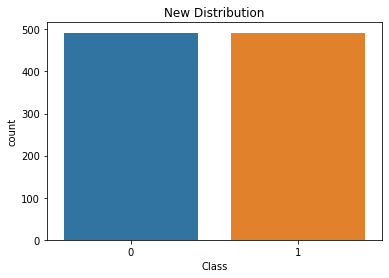

In [19]:
sns.countplot('Class', data=df2)
plt.title('New Distribution')
plt.show()

So, let's try Logistic Regression on this small sample!

In [20]:
X_sample = df2.drop('Class', axis=1)
y_sample = df2['Class']

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=1)

X_train_sample = X_train_sample.values
X_test_sample = X_test_sample.values
y_train_sample = y_train_sample.values
y_test_sample = y_test_sample.values

In [21]:
# Logistic Regression 
lgparameters = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

gslg = GridSearchCV(LogisticRegression(), lgparameters)
gslg.fit(X_train_sample, y_train_sample)

# We automatically get the logistic regression with the best parameters.
logistic_regression_sample = gslg.best_estimator_

In [22]:
scorelog = cross_val_score(logistic_regression_sample, X_train_sample, y_train_sample, cv=5)
print('Logistic Regression Cross Validation Score: ', round(scorelog.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.52%


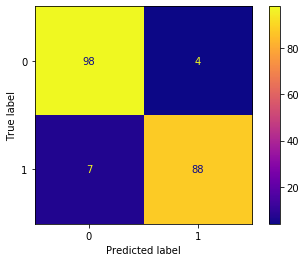

In [23]:
plot_confusion_matrix(logistic_regression_sample, X_test_sample, y_test_sample, cmap='plasma')

The model is working well on the small subset we randomly extracted... The next step is to use the trained model with the whole dataset and the results.

In [26]:
us_X = df.drop('Class', axis=1)
us_y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


for train_index, test_index in sss.split(us_X, us_y):
    print("Train:", train_index, "Test:", test_index)
    us_Xtrain, us_Xtest = us_X.iloc[train_index], us_X.iloc[test_index]
    us_ytrain, us_ytest = us_y.iloc[train_index], us_y.iloc[test_index]
    
us_Xtrain = us_Xtrain.values
us_Xtest = us_Xtest.values
us_ytrain = us_ytrain.values
us_ytest = us_ytest.values 



Train: [ 56946  56947  56948 ... 284804 284805 284806] Test: [    0     1     2 ... 64615 65247 66012]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56946  56947  56948 ... 123086 123462 124388]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113910 113911 113912 ... 180191 180286 180628]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170871 170872 170873 ... 230678 231486 231724]
Train: [     0      1      2 ... 230678 231486 231724] Test: [227842 227843 227844 ... 284804 284805 284806]


In [27]:
for train, test in sss.split(us_Xtrain, us_ytrain):
    us_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), logistic_regression_sample) 
    us_model = us_pipeline.fit(us_Xtrain, us_ytrain)
    us_prediction = us_model.predict(us_Xtrain)

In [28]:
print('---' * 40)
print('Train Evaluation of Logistic Regression on undersampled data:\n')
print("Accuracy Score: {:.2f}".format(us_pipeline.score(us_Xtrain, us_ytrain)))
print("Precision Score: {:.2f}".format(precision_score(us_ytrain, us_prediction)))
print("Recall Score: {:.2f}".format(recall_score(us_ytrain, us_prediction)))
print("F1 Score: {:.2f}".format(f1_score(us_ytrain, us_prediction)))
print('---' * 40)

------------------------------------------------------------------------------------------------------------------------
Train Evaluation of Logistic Regression on undersampled data:

Accuracy Score: 0.39
Precision Score: 0.00
Recall Score: 0.96
F1 Score: 0.01
------------------------------------------------------------------------------------------------------------------------


In [29]:
labels = ['No Fraud', 'Fraud']
us_pred = us_model.predict(us_Xtest)
print(classification_report(us_ytest, us_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.40      0.57     56863
       Fraud       0.00      0.97      0.01        98

    accuracy                           0.40     56961
   macro avg       0.50      0.68      0.29     56961
weighted avg       1.00      0.40      0.57     56961



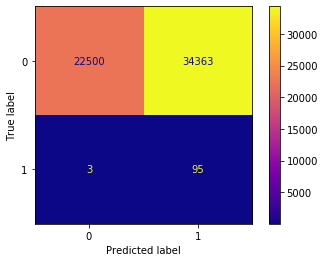

In [30]:
plot_confusion_matrix(us_model, us_Xtest, us_ytest, cmap='plasma')

Unfortunately, the model trained on undersampled data has lost too much information (remember, we went from 480315 to 492 rows of non-frauds!). The Recall is good (it identifies a fraud most of the time), but there are thoundands of "fake alarms" that can become a huge problem with real-life customers. 

## SMOTE + Logistic Regression

Instead of undersampling, let's see how the model performs with SMOTE, a technique that oversamples the dataset, populating it with new, syntethic data in order to balance the ratio.

In [31]:
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)
#I'm using the original dataset for the cross validation!

oldX = df.drop('Class', axis=1)
oldy = df['Class']

for train_index, test_index in sss.split(oldX, oldy):
    print("Train:", train_index, "Test:", test_index)
    oldX_train, oldX_test = oldX.iloc[train_index], oldX.iloc[test_index]
    oldy_train, oldy_test = oldy.iloc[train_index], oldy.iloc[test_index]

Train: [ 56946  56947  56948 ... 284804 284805 284806] Test: [    0     1     2 ... 64615 65247 66012]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56946  56947  56948 ... 123086 123462 124388]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113910 113911 113912 ... 180191 180286 180628]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170871 170872 170873 ... 230678 231486 231724]
Train: [     0      1      2 ... 230678 231486 231724] Test: [227842 227843 227844 ... 284804 284805 284806]


In order to search for the best hyperparameters, I used a RandomizedSearch (faster than Gridsearch) for the Logistic Regression

In [32]:
for train, test in sss.split(oldX_train, oldy_train):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model = pipeline.fit(oldX_train, oldy_train)
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(oldX_train)

In [33]:
print('---' * 40)
print('Train Evaluation of Logistic Regression on oversampled data with SMOTE:\n')
print("Accuracy Score: {:.2f}".format(pipeline.score(oldX_train, oldy_train)))
print("Precision Score: {:.2f}".format(precision_score(oldy_train, prediction)))
print("Recall Score: {:.2f}".format(recall_score(oldy_train, prediction)))
print("F1 Score: {:.2f}".format(f1_score(oldy_train, prediction)))
print('---' * 40)

------------------------------------------------------------------------------------------------------------------------
Train Evaluation of Logistic Regression on oversampled data with SMOTE:

Accuracy Score: 0.98
Precision Score: 0.07
Recall Score: 0.92
F1 Score: 0.12
------------------------------------------------------------------------------------------------------------------------


In [34]:
labels = ['No Fraud', 'Fraud']
smote_pred = best_est.predict(oldX_test)
print(classification_report(oldy_test, smote_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56863
       Fraud       0.06      0.92      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.55     56961
weighted avg       1.00      0.98      0.99     56961



<Figure size 1440x864 with 0 Axes>

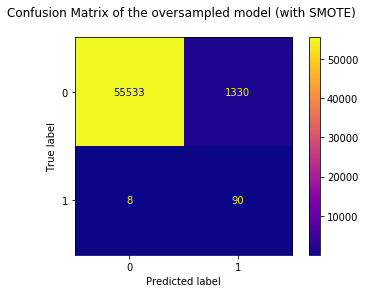

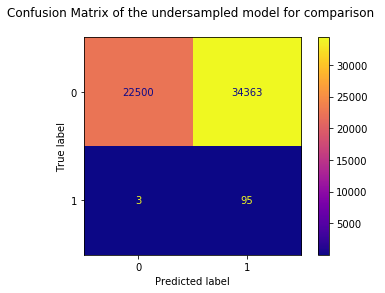

In [36]:
plt.figure(figsize = (20,12))
plot_confusion_matrix(best_est, oldX_test, oldy_test, cmap='plasma')
plt.title('Confusion Matrix of the oversampled model (with SMOTE) \n')
plt.show()  

plot_confusion_matrix(us_model, oldX_test, oldy_test, cmap='plasma')
plt.title('Confusion Matrix of the undersampled model for comparison \n')
plt.show()  
